# Rating Prediction Model using Machine Learning
TF-IDF Vectorization · Logistic Regression · Model Evaluation

## 1. Import Library & Load Dataset
Pada tahap ini, kita memuat dataset hasil cleaning dari proses NLP sebelumnya.
Dataset sudah mengandung kolom penting seperti:
- cleaned_content → teks sudah dibersihkan
- sentiment_title / sentiment_content → bisa dipakai sebagai fitur tambahan
- topic_label → dari topic modeling


In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

In [23]:
df = pd.read_csv('../data/cleaned/amazon_cleaned_reviews.csv')
df.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,...,product_link,main_category,cleaned_title,cleaned_content,cleaned_all,sentiment_title,sentiment_content,all_text_topic_model,topic,topic_label
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,64.0,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...",...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,Computers&Accessories,satisfi charg realli fast valu money product r...,look durabl charg fine no complain charg reall...,satisfi charg realli fast valu money product r...,0.8910,0.6908,satisfi charg realli fast valu money product r...,3,Pengiriman & Packaging
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,43.0,4.0,43994.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...",...,https://www.amazon.in/Ambrane-Unbreakable-Char...,Computers&Accessories,a good braid cabl your type c devic good quali...,i order cabl connect phone android auto car th...,a good braid cabl your type c devic good quali...,0.9652,0.9605,a good braid cabl your type c devic good quali...,3,Pengiriman & Packaging
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,90.0,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...",...,https://www.amazon.in/Sounce-iPhone-Charging-C...,Computers&Accessories,good speed earlier version good product work g...,not quit durabl nice product work well it real...,good speed earlier version good product work g...,0.9638,-0.3744,good speed earlier version good product work g...,3,Pengiriman & Packaging
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329.0,699.0,53.0,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...",...,https://www.amazon.in/Deuce-300-Resistant-Tang...,Computers&Accessories,good product good one nice realli nice product...,good product long wire charg good nice i bough...,good product good one nice realli nice product...,0.9694,0.9657,good product good one nice realli nice product...,3,Pengiriman & Packaging
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154.0,399.0,61.0,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...",...,https://www.amazon.in/Portronics-Konnect-POR-1...,Computers&Accessories,as good origin decent good one secondari use b...,bought instead origin appl work rs not fast ap...,as good origin decent good one secondari use b...,0.9559,0.9724,as good origin decent good one secondari use b...,3,Pengiriman & Packaging


In [24]:
def convert_rating(r):
    if r <= 2:
        return "Low"
    elif r == 3:
        return "Mid"
    else:
        return "High"

df["rating_class"] = df["rating"].apply(convert_rating)
df["rating_class"].value_counts()


rating_class
High    1459
Mid        4
Low        1
Name: count, dtype: int64

## 2. Feature Engineering

Encoding

In [6]:
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["rating_class"])
encoder.classes_

array(['High', 'Low', 'Mid'], dtype=object)

Split Train n Test

In [8]:
X = df["cleaned_content"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 3. Model

In [9]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [11]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

cw = dict(zip(classes, class_weights))
cw

{0: 0.3347627215551744, 1: 390.3333333333333, 2: 97.58333333333333}

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=3000,
    class_weight=cw,
    multi_class='multinomial'
)

model.fit(X_train_tfidf, y_train)

c:\Users\acer\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight={0: 0.3347627215551744, 1: 390.3333333333333,
                                 2: 97.58333333333333},
                   max_iter=3000, multi_class='multinomial')

## Evaluasi

In [16]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_tfidf)

print("Classification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=encoder.classes_,
    labels=range(len(encoder.classes_)) #provide ALL possible integer labels (e.g., [0, 1, 2])
))


Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       293
         Low       0.00      0.00      0.00         0
         Mid       0.00      0.00      0.00         0

    accuracy                           1.00       293
   macro avg       0.33      0.33      0.33       293
weighted avg       1.00      1.00      1.00       293



c:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acer\anaconda3\Lib\site-packages\sk

c:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


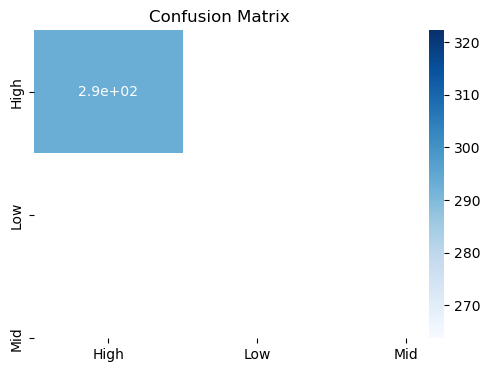

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.show()

testing prediction

In [21]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from src.nlp_preprocessing import clean_text

sample = "the product works perfectly and I love the design"

sample_clean = clean_text(sample)
sample_vec = tfidf.transform([sample_clean])

pred = model.predict(sample_vec)[0]
encoder.classes_[pred]


'High'

## Feature Engineering Regression

Pada bagian ini saya membangun model regresi untuk memprediksi rating produk dalam bentuk angka (1–5).

In [26]:
df["review_length"] = df["cleaned_content"].apply(lambda x: len(x.split()))
features = ["review_length"]

X_reg = df[features]
y_reg = df["rating"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [27]:
rf = RandomForestRegressor(n_estimators=250, random_state=42)
rf.fit(Xr_train, yr_train)

yr_pred = rf.predict(Xr_test)

In [28]:
mse = mean_squared_error(yr_test, yr_pred)
r2 = r2_score(yr_test, yr_pred)

print("MSE:", mse)
print("R2 Score:", r2)

MSE: 0.09993765130521648
R2 Score: -0.28791479302230516


In [29]:
sample_review = "this product is absolutely great and worth the money"

sample_clean = clean_text(sample_review)
sample_len = len(sample_clean.split())

rf.predict([[sample_len]])


array([4.1136])

- Model memprediksi rating sekitar 4.11 / 5
- Berdasarkan input fitur (panjang review)